# CS592-CMLG-Tutorial-2
<a href="https://colab.research.google.com/drive/1At_gCWaiMNyh5bVbXNjNkS0XL2vTFyyf?usp=sharing#scrollTo=fkj2-huJhq4h"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Colab"></a>

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                     node_color=color, cmap="Set2")
    plt.show()

# How to store graph data for ML?

## Node classification tasks with mini-batches

In [ ]:
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid

data = Planetoid('./', name='Cora')[0]

In [ ]:
from torch_geometric.loader import NeighborLoader

loader = NeighborLoader(
    data,
    num_neighbors=[3, 2],
    batch_size=2,
    input_nodes=data.train_mask,
    directed=False,
)


In [ ]:
sampled_data = next(iter(loader))
sampled_data

Data(x=[14, 1433], edge_index=[2, 30], y=[14], train_mask=[14], val_mask=[14], test_mask=[14], batch_size=2)

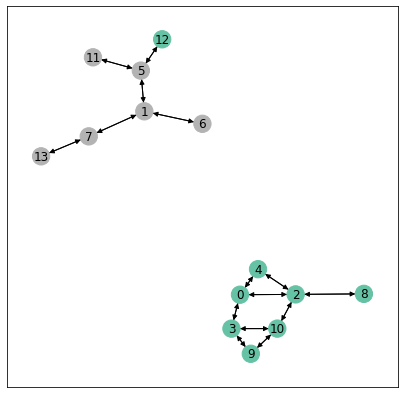

In [ ]:
G = to_networkx(sampled_data)
visualize_graph(G, color=sampled_data.y)

## Graph classification tasks with mini-batches

In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

graph.svg

In [ ]:
edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)
edge_attr = torch.tensor([[4], [3], [2], [1]], dtype=torch.float)

one_graph = Data(x=x, edge_attr=edge_attr, edge_index=edge_index.t().contiguous())
one_graph

Data(x=[3, 1], edge_index=[2, 4], edge_attr=[4, 1])

In [ ]:
one_graph.edge_index

tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])

In [ ]:
data_list = [one_graph] * 4
loader = DataLoader(data_list, batch_size=2)
a_batch_of_graphs = next(iter(loader))
a_batch_of_graphs

DataBatch(x=[6, 1], edge_index=[2, 8], edge_attr=[8, 1], batch=[6], ptr=[3])

In [ ]:
a_batch_of_graphs.edge_index

tensor([[0, 1, 1, 2, 3, 4, 4, 5],
        [1, 0, 2, 1, 4, 3, 5, 4]])

In [ ]:
a_batch_of_graphs.batch

tensor([0, 0, 0, 1, 1, 1])

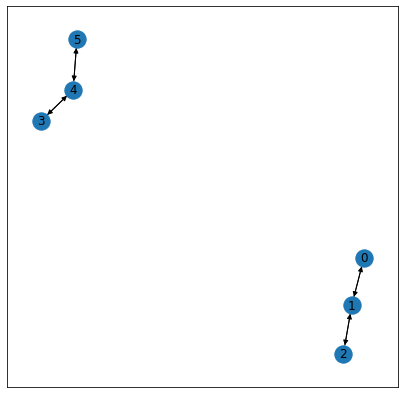

In [ ]:
G = to_networkx(a_batch_of_graphs)
visualize_graph(G, color=a_batch_of_graphs.y)

# Node Classification Tasks

In [ ]:
from torch_geometric.datasets import KarateClub
dataset = KarateClub()
data = dataset[0]

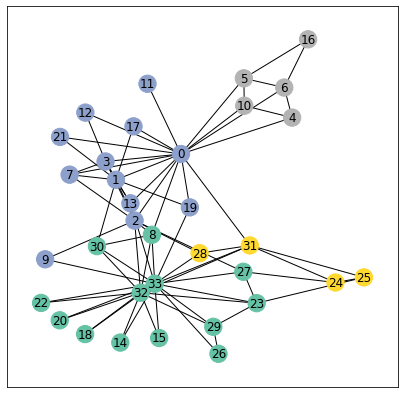

In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

## Graph Convolutional Network (GCN)

In [ ]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, 16)
        self.fc = Linear(16, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)  # Final GNN embedding space.
        return h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 16)
  (fc): Linear(in_features=16, out_features=4, bias=True)
)


## a. Node embeddings

In [ ]:
h = model(data.x, data.edge_index)
data.num_nodes, h.shape

(34, torch.Size([34, 16]))

## b. Classification layer
$y_v = softmax(MLP(h_v^{(L)}))$

In [ ]:
cls_results = model.fc(h)
cls_results.shape, cls_results[:5]

(torch.Size([34, 4]), tensor([[-0.0318, -0.1811,  0.0734,  0.0751],
         [-0.0245, -0.1762,  0.0712,  0.0902],
         [-0.0205, -0.1696,  0.0692,  0.0944],
         [-0.0207, -0.1715,  0.0700,  0.0955],
         [-0.0289, -0.1748,  0.0693,  0.0902]], grad_fn=<SliceBackward0>))

In [ ]:
torch.softmax(cls_results, dim=1)[:5]

tensor([[0.2448, 0.2108, 0.2720, 0.2724],
        [0.2450, 0.2105, 0.2696, 0.2748],
        [0.2453, 0.2113, 0.2683, 0.2751],
        [0.2452, 0.2109, 0.2685, 0.2754],
        [0.2443, 0.2111, 0.2695, 0.2752]], grad_fn=<SliceBackward0>)

# Graph Classification Tasks

In [ ]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

In [ ]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
a_batch = next(iter(train_loader))
a_batch

DataBatch(edge_index=[2, 2636], x=[1188, 7], edge_attr=[2636, 4], y=[64], batch=[1188], ptr=[65])

## Graph Isomorphism Network (GIN)

$$h_v^{(t+1)}=\operatorname{SUM}\left(h_v^{(t)}, \operatorname{SUM}\left(\left\{h_u^{(t)} \mid u \in N_v\right\}\right)\right)$$
$$h_v^{(t+1)} = \operatorname{MLP} (h_v^{(t+1)})$$

$$h_G=\operatorname{SUM}\left(\left\{h_v^{(L)} \mid v \in V\right\}\right)$$

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GINConv
from torch_geometric.nn import global_add_pool


class GIN(torch.nn.Module):
    def __init__(self):
        super(GIN, self).__init__()
        self.conv1 = GINConv(Linear(dataset.num_node_features, 16))
        self.conv2 = GINConv(Linear(16, 16))
        self.conv3 = GINConv(Linear(16, 16))
        self.fc = Linear(16, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)  # Final GNN embedding space.
        return h

model = GIN()
print(model)

GIN(
  (conv1): GINConv(nn=Linear(in_features=7, out_features=16, bias=True))
  (conv2): GINConv(nn=Linear(in_features=16, out_features=16, bias=True))
  (conv3): GINConv(nn=Linear(in_features=16, out_features=16, bias=True))
  (fc): Linear(in_features=16, out_features=2, bias=True)
)


## a. Node embeddings

In [ ]:
h = model(a_batch.x, a_batch.edge_index)
a_batch.x.shape, h.shape, a_batch.y.shape

(torch.Size([1188, 7]), torch.Size([1188, 16]), torch.Size([64]))

## b. Readout layer
$$h_G=\operatorname{SUM}\left(\left\{h_v^{(L)} \mid v \in V\right\}\right)$$


In [ ]:
a_batch.batch[:60]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


<img width="40%" src="https://raw.githubusercontent.com/rusty1s/pytorch_scatter/master/docs/source/_figures/add.svg?sanitize=true" style="max-width: 100%;">

In [ ]:
readout_results = global_add_pool(h, a_batch.batch)
readout_results.shape

torch.Size([64, 16])

## c. Classification layer

In [ ]:
cls_results = model.fc(h)
cls_results.shape, cls_results[:5]

(torch.Size([1188, 2]), tensor([[ 0.2582, -0.3708],
         [ 0.2582, -0.3708],
         [ 0.2578, -0.4720],
         [ 0.2275, -0.7659],
         [ 0.2275, -0.7659]], grad_fn=<SliceBackward0>))

In [ ]:
torch.softmax(cls_results, dim=1)[:5]

tensor([[0.6523, 0.3477],
        [0.6523, 0.3477],
        [0.6747, 0.3253],
        [0.7298, 0.2702],
        [0.7298, 0.2702]], grad_fn=<SliceBackward0>)

# Create your own GNNs

## a. Create your own conv layers
$$\mathbf{x}_i^{(k)}=\gamma^{(k)}\left(\mathbf{x}_i^{(k-1)}, \square_{j \in \mathcal{N}(i)} \phi^{(k)}\left(\mathbf{x}_i^{(k-1)}, \mathbf{x}_j^{(k-1)}, \mathbf{e}_{j, i}\right)\right)$$

In [ ]:
from torch.nn import Linear
from torch_geometric.nn import MessagePassing


class CustomizedConv(MessagePassing):
    def __init__(self, aggr="add"):  # aggregation function
        super().__init__(aggr=aggr)

    def forward(self, x, edge_index, edge_attr):
        raw_x = x
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)

        # \gamma
        out = out + raw_x

        return out

    # \phi
    def message(self, x_j, edge_attr):
        msg = (x_j + edge_attr).relu()
        return msg

## b. Create your own GNN models


In [ ]:
class CustomizedGNN(torch.nn.Module):
    def __init__(self, node_feat, edge_feat, hidden_size, num_classes):
        super().__init__()
        self.conv1 = CustomizedConv(aggr='mean')
        self.conv2 = CustomizedConv(aggr='mean')
        self.conv3 = CustomizedConv(aggr='mean')

        self.node_fc = Linear(node_feat, hidden_size)
        self.edge_fc = Linear(edge_feat, hidden_size)
        self.classifier_fc = Linear(hidden_size, num_classes)

    def forward(self, x, edge_index, edge_attr):
        x = self.node_fc(x)
        edge_attr = self.edge_fc(edge_attr)

        h = self.conv1(x, edge_index, edge_attr)
        h = h.relu()
        h = self.conv2(h, edge_index, edge_attr)
        h = h.relu()
        h = self.conv3(h, edge_index, edge_attr)  # Final GNN embedding space.
        return h

## c. Test the GNN

In [ ]:
num_node_feat = 10
num_edge_feat = 12
hidden_size = 32
num_classes = 3
model = CustomizedGNN(num_node_feat, num_edge_feat, hidden_size, num_classes)
print(model)

CustomizedGNN(
  (conv1): CustomizedConv()
  (conv2): CustomizedConv()
  (conv3): CustomizedConv()
  (node_fc): Linear(in_features=10, out_features=32, bias=True)
  (edge_fc): Linear(in_features=12, out_features=32, bias=True)
  (classifier_fc): Linear(in_features=32, out_features=3, bias=True)
)


In [ ]:
x = torch.randn((5, num_node_feat))
edge_attr = torch.randn((10, num_edge_feat))
edge_index = torch.randint(low=0, high=5, size=(2, 10))

In [ ]:
out = model(x, edge_index, edge_attr)
out.shape

torch.Size([5, 32])

In [ ]:
classification_results = torch.softmax(model.classifier_fc(out), dim=1)
classification_results[: 5]

tensor([[1.2486e-01, 8.7314e-01, 1.9953e-03],
        [9.7969e-01, 1.9465e-02, 8.4544e-04],
        [9.8238e-01, 1.6418e-02, 1.2034e-03],
        [9.9723e-01, 2.3976e-03, 3.6936e-04],
        [7.8756e-01, 2.1020e-01, 2.2422e-03]], grad_fn=<SliceBackward0>)